# DEEP NEURAL NETWORKS CLASSIFICATION

Данильченко Вадим

-------------------------------------------------------------------------------------------------------------------------------

классификация тематик обращений клиентов к чат-боту.

class	intent
- 0	узнать возраст бота
- 1	узнать какую музыку слушает бот
- 2	узнать любит ли бот путешествовать
- 3	узнать где работает бот
- 4	узнать информацию про семью бота
- 5	узнать как относится бот к спорту
- 6	узнать где учится бот
- 7	узнать что читает бот
- 8	узнать есть ли у бота животные
- 9	узнать есть ли у бота машина
- 10	узнать как выглядит бот
- 11	узнать как зовут бота
- 12	узнать какие парни/девушки нравятся
- 13	узнать какой пол у бота
- 14	узнать кто такой бот
- 15	узнать кулинарные пристрастия бота
- 16	узнать о чем мечтает бот
- 17	поблагодарить бота
- 18	поприветствовать бота
- 19	попрощаться с ботом
- 20	разослать информацию студентам на email
- 21	узнать как дела
- 22	узнать метеопрогноз на сегодня
- 23	узнать об увлечениях
- 24	узнать откуда бот
- 25	узнать расписание занятий
- 26	узнать чем занимается бот
- 27	услышать анекдот
- 28	узнать о преподавателе
- 29	сделать уведомление студентам канала
- 30	узнать что умеет бот

In [2]:
import re
import tensorflow
import joblib
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, FastText
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import trange
from keras.preprocessing.sequence import pad_sequences
from pymorphy2 import MorphAnalyzer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Input, Concatenate, Dense, Activation, Flatten, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional, Multiply, add, GRU, Reshape, TimeDistributed, GlobalMaxPooling1D
from keras import regularizers
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [9]:
# загрузим все фразы
bazonka = pd.read_excel(r'C:\Users\vndan\projects\netology_chat_bot\kb\kb_new.xlsx', sheet_name='kb')
bazonka.shape

dialogues = joblib.load(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\dialogues_prepared.pkl')
intents = open(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\_intents.txt', encoding='utf-8').readlines()
intents =  [str(i).replace('\n', '') for i in intents]
phrases = open(r'F:\ОБУЧЕНИЕ\CHAT-BOTs\тексты\dialogues\_phrases.txt', encoding='utf-8').readlines()
phrases =  [str(i).replace('\n', '') for i in phrases]
yes_no = pd.read_excel(r'C:\Users\vndan\projects\netology_chat_bot\kb\train_data_yes.xlsx')
# объединим все диалоги в один список
concatted_phrases = dialogues.participant_1.tolist() + dialogues.participant_2.tolist() + intents + phrases + bazonka['message'].tolist() + yes_no['message'].tolist()
concatted_phrases = intents + phrases + bazonka['message'].tolist() + yes_no['message'].tolist()
concatted_phrases[620:655]

['привет как настроение',
 'привет как настроеньице',
 'привет как поживаешь',
 'привет как твои дела',
 'привет как ты',
 'привет как ты чем занимаешься',
 'привет как у вас дела',
 'привет как у тебя дела',
 'привет привет как делишки',
 'приветик как дела',
 'приветики как дела',
 'сам как',
 'тоже не плохо',
 'ты как',
 'у меня все хорошо а у тебя',
 'узнать как дела',
 'че как',
 'эээй привет как дела ты откуда',
 'будет ли сегодня дождь',
 'какая погода завтра',
 'погода',
 'завтра какая погода',
 'завтра солнечно',
 'какая погода',
 'метеопрогноз',
 'метеопрогноз на сегодня',
 'прогноз погоды',
 'прогноз погоды на сегодня',
 'сегодня солнечно',
 'сколько градусов',
 'температуру можешь сказать',
 'узнать метеопрогноз на сегодня',
 'узнать погоду',
 'что за окном',
 'метеопрогноз на завтра']

In [10]:
# токенизируем
def text2seq(phrase):
    phrase = re.sub('ё', 'е', phrase)
    return text_to_word_sequence(str(phrase), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

text = [text2seq(phrase) for phrase in concatted_phrases]
text[:2]

[['поприветствовать', 'бота'], ['поприветствовать', 'бота']]

In [12]:
# лемматизируем
morph = MorphAnalyzer()
sentences = [[] for _ in range(len(text))]
for sentence in trange(len(text)):
    phrase = text[sentence]
    for word in phrase:
        sentences[sentence].append(morph.parse(word)[0].normal_form)

100%|██████████| 928/928 [00:00<00:00, 1907.46it/s]


подготвока эмбеддингов

In [13]:
# обучим модели
size = 50
window = 5
ft = FastText(sentences=sentences, size=size, window=window, min_count=1, seed=777, workers=-1, max_vocab_size=None)
wvec = Word2Vec(sentences=sentences, size=size, window=window, min_count=1, seed=777, workers=-1, max_vocab_size=None)

In [16]:
wvec.wv.__getitem__('email')

array([ 4.4888100e-03, -4.3321531e-03, -7.0383730e-03,  3.7250475e-03,
        6.3173040e-03, -4.3068430e-03,  7.7224718e-03, -8.3888927e-04,
        6.9051697e-03,  5.2407968e-06, -2.3118393e-03,  8.2551390e-03,
        5.8275014e-03,  8.6410902e-03, -4.8663858e-03, -5.6927735e-03,
        9.9577121e-03,  4.2664390e-03, -7.4034702e-04,  3.7775137e-03,
       -7.8218291e-03,  2.9782914e-03, -7.1067610e-03, -9.6850265e-03,
       -8.4634265e-03,  4.1766507e-03,  7.7311094e-03, -4.4546474e-04,
        2.0764440e-03, -9.0079419e-03,  6.6580609e-03,  3.8441890e-03,
        4.7897450e-03,  2.4347671e-03,  4.3045580e-03,  2.0739001e-03,
        8.0486061e-03, -2.9068119e-03,  8.9438614e-03, -4.1918352e-04,
        1.0236155e-03,  7.7276304e-03,  2.6732073e-03,  3.0148021e-04,
        2.8749495e-03,  1.4593835e-04,  1.8863124e-03,  3.0623036e-03,
        3.3497300e-03,  8.2182596e-03], dtype=float32)

In [17]:
# функция, объединяющая результаты моделей в один вектор
def get_item(word):
    if word in wvec:
        w = wvec.wv.__getitem__(word)
    else:
        w = np.zeros(wvec.wv.vector_size)
    if word in ft:
        f = ft.wv.__getitem__(word)
    else:
        f = np.zeros(ft.wv.vector_size)
    return np.concatenate([w,f])

get_item('email')

array([ 4.4888100e-03, -4.3321531e-03, -7.0383730e-03,  3.7250475e-03,
        6.3173040e-03, -4.3068430e-03,  7.7224718e-03, -8.3888927e-04,
        6.9051697e-03,  5.2407968e-06, -2.3118393e-03,  8.2551390e-03,
        5.8275014e-03,  8.6410902e-03, -4.8663858e-03, -5.6927735e-03,
        9.9577121e-03,  4.2664390e-03, -7.4034702e-04,  3.7775137e-03,
       -7.8218291e-03,  2.9782914e-03, -7.1067610e-03, -9.6850265e-03,
       -8.4634265e-03,  4.1766507e-03,  7.7311094e-03, -4.4546474e-04,
        2.0764440e-03, -9.0079419e-03,  6.6580609e-03,  3.8441890e-03,
        4.7897450e-03,  2.4347671e-03,  4.3045580e-03,  2.0739001e-03,
        8.0486061e-03, -2.9068119e-03,  8.9438614e-03, -4.1918352e-04,
        1.0236155e-03,  7.7276304e-03,  2.6732073e-03,  3.0148021e-04,
        2.8749495e-03,  1.4593835e-04,  1.8863124e-03,  3.0623036e-03,
        3.3497300e-03,  8.2182596e-03, -2.1878562e-03,  1.2443402e-03,
       -5.7335729e-03, -4.1821520e-03,  4.0046623e-05, -3.0518495e-03,
      

In [19]:
# создадим словарь индексов слов
id2word = {k+1:v for k,v in enumerate(list(wvec.wv.vocab.keys()))}

# на всякий случай проверим и добавим словарь fasttext
i = max(id2word)
for word in list(ft.wv.vocab.keys()):
    if word not in id2word.values():
        i+=1
        id2word[i] = word

# добавим UNK, в него будут преобразовываться все неизвестные слова
id2word[0] ='UNK'

# также словарь слов в индекс
word2id = {v: k for k, v in id2word.items()}

In [20]:
# функция преобразования входящей фразы в вектор
def vectorize(phrase):
    phrase = ' '.join(text2seq(phrase))
    vector_tmp = []
    for word in phrase:
        word = morph.parse(word)[0].normal_form
        if word not in word2id:
            word = 'UNK'
        vector_tmp.append(get_item(word))
    return np.mean(vector_tmp, axis=0)

подготовим модель

In [21]:
# объявим гиперпараметры дальнейшей модели
MAX_SEQ_LEN = 15
# MAX_VOCAB_SIZE = len(wvec.wv.vocab)+1
MAX_VOCAB_SIZE = len(id2word)+1
EMBEDDING_DIM = len(get_item('привет'))
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 30
CLASSES = len(set(bazonka['intent'].tolist()))

In [23]:
########################## MODEL ##############################
# подготовим эмбеддинг
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word in word2id:
    i = word2id[word]
    embedding_vector = get_item(word)
    embedding_matrix[i] = embedding_vector 
embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=True
                            )

input_ = Input(shape=(MAX_SEQ_LEN, ))
emb = embedding_layer(input_)

# отправим на вход 3м моделям

# 1
x3 = Conv1D(filters=int(EMBEDDING_DIM/3), kernel_size=3, strides=1, padding='same', name='model1_conv1_k3')(emb)
x2 = Conv1D(filters=int(EMBEDDING_DIM/2), kernel_size=2, strides=1, padding='same', name='model1_conv1_k2')(emb)
x1 = Conv1D(filters=EMBEDDING_DIM, kernel_size=1, strides=1, padding='same', name='model1_conv1_k1')(emb)
x = Concatenate(name='model1_concat')([x3, x2, x1])
x = Activation('relu', name='model1_relu')(x)
x = Conv1D(filters=EMBEDDING_DIM, kernel_size=1, name='model1_conv1_k1_2')(x)

# 2
xx = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True, kernel_regularizer=regularizers.l2(0.1), activation='tanh'), name='model2_bi1')(emb)
xx = Bidirectional(LSTM(int(EMBEDDING_DIM/2), return_sequences=True, kernel_regularizer=regularizers.l2(0.1)), name='model2_bi2')(xx)

# 3
xxx = GRU(EMBEDDING_DIM, return_sequences=True, name='model3_gru')(emb)
xxx = Dense(EMBEDDING_DIM, activation='relu', name='model3_dense')(xxx)

# объединение моделей результатов моделей в единый сверточный слой 
x = Concatenate()([x, xx, xxx])
x = MaxPooling1D()(x)

# преобразуем в полносвязный слой
x = Flatten()(x)
x = Dense(x.shape[1], activation='relu')(x)
x = Dropout(0.2)(x)

# выходной слой с количеством нейронов согласно к-ву классов
output = Dense(CLASSES, activation='softmax')(x)

In [25]:
model = Model(input_, output)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 100)      42300       input_1[0][0]                    
__________________________________________________________________________________________________
model1_conv1_k3 (Conv1D)        (None, 15, 33)       9933        embedding[0][0]                  
__________________________________________________________________________________________________
model1_conv1_k2 (Conv1D)        (None, 15, 50)       10050       embedding[0][0]                  
____________________________________________________________________________________________

подготовим данные для обучения

In [26]:
# определим базу знаний
train_df = bazonka

# немного измененная функция векторизации
def preprocess(text):
    temp_seq = []
    # text = ' '.join([word for word in morph.lemmatize(text) if not any(i in word for i in [' ', '\n'])])
    for word in text2seq(str(text)):
        word = morph.parse(word)[0].normal_form
        # word = morph.lemmatize(word)[0]
        if word not in word2id:
            word = 'UNK'
        temp_seq.append(word2id[word])
    return temp_seq

# преобразуем фразы в послeдовательности индексов слов
sequences = []
for phrase in trange(train_df['message'].shape[0]):
    sequences.append(preprocess(train_df['message'].iloc[phrase]))
    
sequences[:5]

100%|██████████| 747/747 [00:00<00:00, 1557.18it/s]


[[87, 72, 88, 89],
 [87, 72, 90, 89],
 [87, 72, 90, 89, 91],
 [87, 90, 72, 89],
 [6, 92, 72, 89]]

In [27]:
# приведем к заданной длине, дополнив нулями
sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
sequences[:5]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 87, 72, 88, 89],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 87, 72, 90, 89],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 87, 72, 90, 89, 91],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 87, 90, 72, 89],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 92, 72, 89]])

In [28]:
# приведем таргет к виду 1xlen(CLASSES) с 1 на месте правильного класса
y = train_df['TARGET'].to_list()
y_binary = to_categorical(y)
print('shape: ', y_binary.shape)
y_binary[:2]

shape:  (747, 31)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [29]:
# разделим на тренировочную и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(sequences, y_binary, test_size=0.1, random_state=777, shuffle=True)

обучим модель

In [30]:
# обучим модель
r = model.fit(x_train,
              y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              verbose=2
              )

Train on 672 samples, validate on 75 samples
Epoch 1/30
672/672 - 7s - loss: 68.0043 - accuracy: 0.9677 - val_loss: 61.3347 - val_accuracy: 0.9677
Epoch 2/30
672/672 - 1s - loss: 57.9005 - accuracy: 0.9677 - val_loss: 51.9943 - val_accuracy: 0.9677
Epoch 3/30
672/672 - 1s - loss: 48.9779 - accuracy: 0.9677 - val_loss: 43.8132 - val_accuracy: 0.9677
Epoch 4/30
672/672 - 1s - loss: 41.1926 - accuracy: 0.9677 - val_loss: 36.7212 - val_accuracy: 0.9677
Epoch 5/30
672/672 - 1s - loss: 34.4647 - accuracy: 0.9677 - val_loss: 30.6264 - val_accuracy: 0.9677
Epoch 6/30
672/672 - 1s - loss: 28.6977 - accuracy: 0.9678 - val_loss: 25.4286 - val_accuracy: 0.9699
Epoch 7/30
672/672 - 1s - loss: 23.7901 - accuracy: 0.9687 - val_loss: 21.0267 - val_accuracy: 0.9695
Epoch 8/30
672/672 - 1s - loss: 19.6406 - accuracy: 0.9707 - val_loss: 17.3192 - val_accuracy: 0.9708
Epoch 9/30
672/672 - 1s - loss: 16.1503 - accuracy: 0.9730 - val_loss: 14.2149 - val_accuracy: 0.9725
Epoch 10/30
672/672 - 1s - loss: 13.2

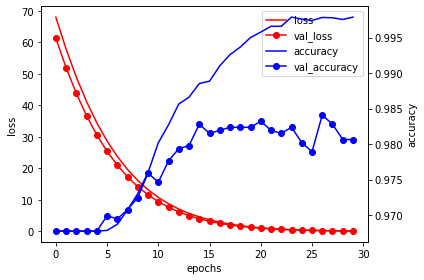

In [32]:
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(r.history['accuracy']), 1)

ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, r.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, r.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [37]:
model.save(r'C:\Users\vndan\projects\netology_chat_bot\models\CNN_classification.hdf5')

In [39]:
test_text = 'узнать расписание занятий'
print(np.max(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))), 
np.argmax(model.predict(pad_sequences([preprocess(test_text)], maxlen=MAX_SEQ_LEN))))

0.98437923 25
